In [1]:
import numpy as np 
import pandas as pd

In [2]:
df = pd.DataFrame(np.load('trial_1.npy'))
df2 = pd.DataFrame(np.load('trial_2.npy'))
df3 = pd.DataFrame(np.load('trial_3.npy'))

In [4]:
df.shape, df2.shape, df3.shape

((38403, 12), (34013, 12), (33880, 12))

In [5]:
trial_cues = np.load('trials.npy')
trial_cues

array([['jaw_clench', 'jaw_clench', 'blink_hard', 'double_blink',
        'jaw_clench', 'jaw_clench', 'blink_hard', 'double_blink',
        'blink_hard', 'jaw_clench_blink', 'jaw_clench',
        'jaw_clench_blink', 'jaw_clench', 'blink_hard',
        'jaw_clench_blink', 'blink_hard', 'double_blink', 'double_blink',
        'jaw_clench', 'jaw_clench_blink', 'jaw_clench', 'double_blink',
        'jaw_clench_blink', 'double_blink', 'jaw_clench_blink',
        'double_blink', 'double_blink', 'double_blink', 'double_blink',
        'jaw_clench_blink', 'blink_hard', 'double_blink', 'double_blink',
        'blink_hard', 'jaw_clench', 'jaw_clench', 'jaw_clench_blink',
        'blink_hard', 'jaw_clench_blink', 'blink_hard'],
       ['jaw_clench', 'jaw_clench_blink', 'double_blink', 'jaw_clench',
        'jaw_clench_blink', 'jaw_clench_blink', 'blink_hard',
        'double_blink', 'jaw_clench', 'jaw_clench_blink', 'blink_hard',
        'blink_hard', 'blink_hard', 'blink_hard', 'jaw_clench',
   

In [73]:
trial_cues[0][15]

'blink_hard'

<Axes: ylabel='Frequency'>

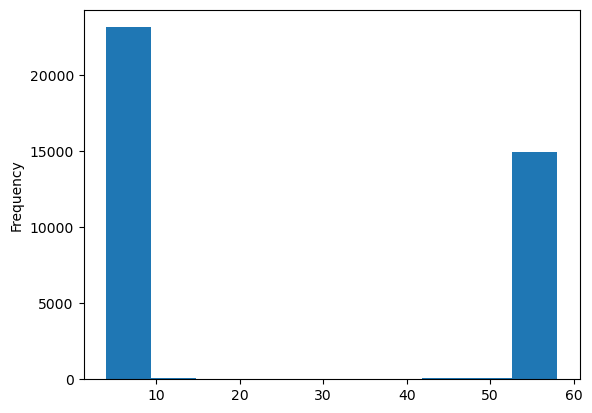

In [51]:
df[9].plot(kind='hist')

In [52]:
df = pd.DataFrame(np.load('trial_1.npy'))
df['onset'] = (df[9].shift(1) < 30) & (df[9] >= 30)
df['offset'] = (df[9].shift(-1) < 30) & (df[9] >= 30)

FileNotFoundError: [Errno 2] No such file or directory: 'trial_1.npy'

In [70]:
artifact_idx = 15
onset_idx = df[df['onset'] == True].index[artifact_idx]
offset_idx = df[df['offset'] == True].index[artifact_idx]

In [71]:
onset_idx, offset_idx

(19894, 20269)

<Axes: >

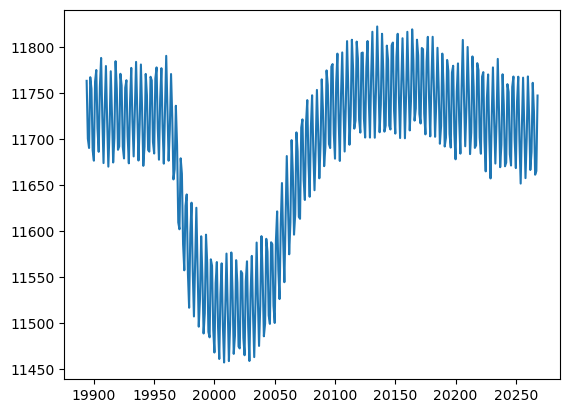

In [72]:
# 3 is the third channel
df[3].iloc[onset_idx:offset_idx].plot(kind='line')

In [25]:
df2['onset'] = (df2[9].shift(1) < 30) & (df2[9] >= 30)
df2['offset'] = (df2[9].shift(-1) < 30) & (df2[9] >= 30)

In [49]:
artifact_idx = 11
onset_idx = df2[df2['onset'] == True].index[5]
offset_idx = df2[df2['offset'] == True].index[6]

<Axes: >

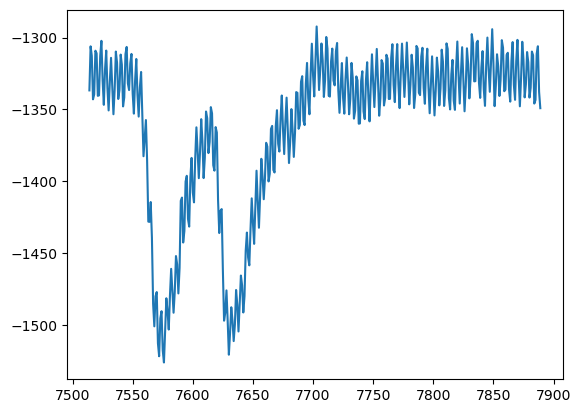

In [50]:
# 3 is the third channel
df2[3].iloc[onset_idx: offset_idx].plot(kind='line')

<Axes: ylabel='Frequency'>

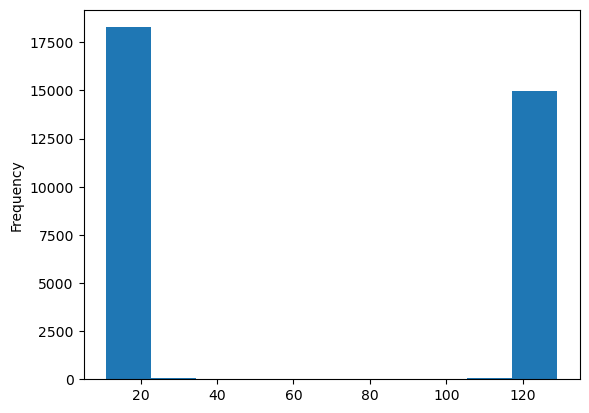

In [29]:
df2[9].plot(kind='hist')

In [42]:
len(df2[df2['onset'] == True].index), len(df2[df2['offset'] == True].index),

(40, 40)

In [43]:
df2[df2['onset'] == True].index

Index([ 3746,  4497,  5252,  6008,  6759,  7514,  8269,  9020,  9775, 10530,
       11281, 12037, 12792, 13543, 14298, 15053, 15808, 16559, 17314, 18074,
       18825, 19580, 20335, 21086, 21841, 22596, 23347, 24102, 24857, 25613,
       26363, 27114, 27870, 28625, 29376, 30131, 30886, 31637, 32392, 33147],
      dtype='int64')

In [44]:
df2[df2['offset'] == True].index

Index([   59,  4123,  4878,  5629,  6384,  7139,  7890,  8645,  9401, 10152,
       10911, 11662, 12413, 13168, 13923, 14679, 15429, 16185, 16940, 17695,
       18446, 19205, 19956, 20711, 21462, 22217, 22972, 23728, 24479, 25234,
       25985, 26744, 27495, 28246, 29005, 29756, 30507, 31263, 32018, 32769],
      dtype='int64')

In [ ]:
df2[3].iloc[onset_idx:]:offset_idx]#.plot(kind='line')

12037   -1352.593464
12038   -1384.578810
12039   -1419.805160
12040   -1376.778051
12041   -1345.887941
            ...     
33502   -1193.247878
33503   -1132.987575
33504   -1107.260717
33505   -1158.848543
33506   -1189.492785
Name: 3, Length: 21470, dtype: float64